## **Question 1 : vérifier que le GPU est bien sélectionné**

In [47]:
#####################################################

## **Instruction 1 : Installation de pytorch lightning**

In [1]:
!pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu126

Looking in indexes: https://download.pytorch.org/whl/cu126


## **Instruction 2 : connecter votre notebook à la plateforme WanDB**

In [2]:
import wandb
wandb.login(key="9414e8ff95ebd7016321b49a7cd54fac7c75fd9d")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: C:\Users\maxim\_netrc
wandb: Currently logged in as: maximilien003 (maximilien003-universit-de-mons) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## **Instruction 3 : importation des librairies**

In [3]:
import pytorch_lightning as pl
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST
from torchmetrics.classification import MulticlassConfusionMatrix
from torchmetrics.functional.classification import multiclass_accuracy
from pytorch_lightning.loggers import CSVLogger
import matplotlib.pyplot as plt
from pytorch_lightning.loggers import TensorBoardLogger , WandbLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from torchinfo import summary
from lightning_fabric.utilities.seed import seed_everything
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset
import numpy as np
from torchmetrics.classification import MulticlassAccuracy
seed_everything(42,workers=True)

Seed set to 42


42

## **Instruction 4 : définir les paramètres d'entrainement**

In [4]:
NUM_CLASSES = 10
BATCH_SIZE=64 #@param [1,2,4,8,16,32,64,128] {type:"raw"}
EPOCHS=10 #@param [1,5, 10,20,50,100,200] {type:"raw"}
DATA_DIR="."
LOG_DIR="logs/"
ACCELERATOR= "auto" #@param ["cpu","gpu","auto"]

## **Instruction 5 : téléchargement de la base de données MNIST**

In [5]:
transform = transforms.Compose([transforms.ToTensor()])
train_ds = MNIST(DATA_DIR, train=True, download=True, transform=transform)
test_ds = MNIST(DATA_DIR, train=False, download=True, transform=transform)

## **Instruction 6 : Divison des données et création des tenseurs/dataloaders**

In [6]:
targets = train_ds.targets

train_idx, valid_idx= train_test_split(np.arange(len(targets)), test_size=0.2, random_state=42, shuffle=True, stratify=targets)
train_ds_subset = Subset(train_ds, train_idx)
val_ds = Subset(train_ds, valid_idx)

# create train , test and val loaders
train_loader = DataLoader(train_ds_subset, batch_size=BATCH_SIZE)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)


## **Question 2:  Inspecter le format de vos données d'entrainement, validation et test**

In [7]:
# Affichage des informations
print(f"Train set: {len(train_ds)} samples, shape: {train_ds[0][0].shape}, type: {type(train_ds[0][0])}")
print(f"Validation set: {len(val_ds)} samples, shape: {val_ds[0][0].shape}, type: {type(val_ds[0][0])}")
print(f"Test set: {len(test_ds)} samples, shape: {test_ds[0][0].shape}, type: {type(test_ds[0][0])}")

Train set: 60000 samples, shape: torch.Size([1, 28, 28]), type: <class 'torch.Tensor'>
Validation set: 12000 samples, shape: torch.Size([1, 28, 28]), type: <class 'torch.Tensor'>
Test set: 10000 samples, shape: torch.Size([1, 28, 28]), type: <class 'torch.Tensor'>


## **Instruction 7 : visualiser 10 échantions de données/images**

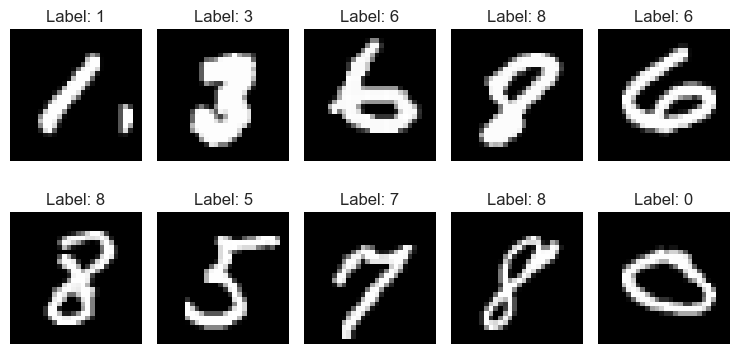

In [8]:
# Get one batch of data
images, labels = next(iter(train_loader))
num_row = 2
num_col = 5
fig, axes = plt.subplots(num_row, num_col, figsize=(1.5 * num_col, 2 * num_row))
for i in range(10):
    ax = axes[i // num_col, i % num_col]
    ax.imshow(images[i].squeeze(), cmap='gray')
    ax.set_title('Label: {}'.format(labels[i].item()))
    ax.axis('off')
plt.tight_layout()
plt.show()

## **Question 3 : analyser attentivement la classe «MNISTModel» avant de la compléter**

In [9]:
class MNISTModel(pl.LightningModule):
    def __init__(self, model, optimizer, num_classes=NUM_CLASSES, lr=1e-4):
        super(MNISTModel, self).__init__()
        self.model = model
        self.num_classes = num_classes
        self.optimizer = optimizer
        self.lr = lr
        self.train_acc = MulticlassAccuracy(num_classes=num_classes)
        self.val_acc = MulticlassAccuracy(num_classes=num_classes)
        self.test_acc = MulticlassAccuracy(num_classes=num_classes)

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.train_acc(y_hat, y)
        self.log_dict({'train_loss': loss, "train_acc": acc}, on_step=False, prog_bar=True, logger=True, on_epoch=True)
        return loss

    def on_train_epoch_end(self):
        self.train_acc.reset()

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.val_acc(y_hat, y)
        self.log_dict({'val_loss': loss, "val_acc": acc}, on_step=False, prog_bar=True, logger=True, on_epoch=True)
        return loss

    def on_validation_epoch_end(self):
        self.val_acc.reset()

    def test_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        loss = F.cross_entropy(y_hat, y)
        acc = self.test_acc(y_hat, y)
        self.log_dict({'test_loss': loss, "test_acc": acc}, on_step=False, prog_bar=True, logger=True, on_epoch=True)
        return loss

    def on_test_epoch_end(self):
        self.test_acc.reset()

    def configure_optimizers(self):
        return self.optimizer(self.model.parameters(), lr=self.lr, weight_decay=1e-4)

---
# **Partie I : MLP à une seule couche**



## **Instruction 8 : définition de l'architecture neuronale  du  premier modèle à 1 seule couche**

In [10]:
class MLP1(nn.Module):
    def __init__(self):
        super(MLP1, self).__init__()
        self.l1 = nn.Linear(28 * 28, 10)
    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten
        x = self.l1(x)
        return x

## **Instruction 9 : visualiser l'architecture de votre  premier modèle avec la fonction summary()**

In [58]:
mlp1 = MLP1()
summary(mlp1,(1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
MLP1                                     [1, 10]                   --
├─Linear: 1-1                            [1, 10]                   7,850
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.01
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.03
Estimated Total Size (MB): 0.03

## **Question 4 : compléter le code (SGD avec lr='0.01' et lancer l'entrainement**

In [59]:
EPOCHS = 10
wandb_logger = WandbLogger(
    project="TP4 MNIST",
    name="mlp1_10epochs",
    log_model=True,
)
optimizer = torch.optim.SGD
model1  = MNISTModel(mlp1,optimizer=optimizer,lr=0.01)

# Initialize a trainer
trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=EPOCHS,
    logger=wandb_logger,
)
# Train the model ⚡
trainer.fit(model1, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | MLP1               | 7.9 K  | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\maxim\OneDrive\Documents\UMONS\BAB3\Q2 - Intelligence Artificielle\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\maxim\OneDrive\Documents\UMONS\BAB3\Q2 - Intelligence Artificielle\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


In [60]:
trainer.test(model1, test_loader)
wandb.finish()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\maxim\OneDrive\Documents\UMONS\BAB3\Q2 - Intelligence Artificielle\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.905625581741333
        test_loss           0.34880688786506653
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇█
test_acc,▁
test_loss,▁
train_acc,▁▆▆▇▇▇████
train_loss,█▃▂▂▂▁▁▁▁▁
trainer/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
val_acc,▁▄▅▆▆▇▇▇██
val_loss,█▅▃▃▂▂▂▁▁▁
epoch,10
test_acc,0.90563
test_loss,0.34881


In [61]:
EPOCHS = 50
wandb_logger = WandbLogger(
    project="TP4 MNIST",
    name="mlp1_50epochs",
    log_model=True,
)
optimizer = torch.optim.SGD
model1  = MNISTModel(mlp1,optimizer=optimizer,lr=0.01)

# Initialize a trainer
trainer = pl.Trainer(
    accelerator=ACCELERATOR,
    max_epochs=EPOCHS,
    logger=wandb_logger,
)
# Train the model ⚡
trainer.fit(model1, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | MLP1               | 7.9 K  | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)
5         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


## **Question 4b:vérifier/interpréter résultats d'entraînement de votre 1er modèle MLP via Wandb**

https://wandb.ai/maximilien003-universit-de-mons/TP4%20MNIST?nw=nwusermaximilien003

## **Question 5 : évaluer votre premier modèle avec les données de test**

In [62]:
trainer.test(model1, test_loader)
wandb.finish()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9175533056259155
        test_loss           0.28627413511276245
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇█
test_acc,▁
test_loss,▁
train_acc,▁▂▂▂▃▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇███████
train_loss,█▇▇▇▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇████
val_acc,▁▁▂▂▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇████████
val_loss,█▇▇▇▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁
epoch,50
test_acc,0.91755
test_loss,0.28627


---
## **Partie II : MLP à plusieurs couches avec Sigmoid**

## **Question 6 : définir l'architecture neuronale à 5 couches avec Sigmoid (voire l'énonce)**

In [14]:
class MLP2(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[200, 100, 60, 30], output_size=10):
        super(MLP2, self).__init__()

        # Définir les couches linéaires
        self.layer1 = nn.Linear(input_size, hidden_sizes[0])  # 784 -> 200
        self.layer2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])  # 200 -> 100
        self.layer3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])  # 100 -> 60
        self.layer4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])  # 60 -> 30
        self.layer5 = nn.Linear(hidden_sizes[3], output_size)  # 30 -> 10

        # Activation Sigmoid pour les couches cachées
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Aplatir l'entrée (par exemple, de (batch_size, 1, 28, 28) à (batch_size, 784) pour MNIST)
        x = x.view(x.size(0), -1)

        # Passer à travers les couches avec Sigmoid pour les couches cachées
        x = torch.sigmoid(self.layer1(x)) # Couche 1 + Sigmoid
        x = torch.sigmoid(self.layer2(x))  # Couche 2 + Sigmoid
        x = torch.sigmoid(self.layer3(x))  # Couche 3 + Sigmoid
        x = torch.sigmoid(self.layer4(x))  # Couche 4 + Sigmoid
        x = self.layer5(x)  # Couche 5 (sortie, sans activation)

        return x

## **Question 7 : visualiser l'architecture de votre  deuxième modèle avec la fonction summary()**

In [15]:
mlp2_deep_sigmoid = MLP2()
summary(mlp2_deep_sigmoid,(1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
MLP2                                     [1, 10]                   --
├─Linear: 1-1                            [1, 200]                  157,000
├─Linear: 1-2                            [1, 100]                  20,100
├─Linear: 1-3                            [1, 60]                   6,060
├─Linear: 1-4                            [1, 30]                   1,830
├─Linear: 1-5                            [1, 10]                   310
Total params: 185,300
Trainable params: 185,300
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.19
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.74
Estimated Total Size (MB): 0.75

## **Question 8 : lancer l'entrainement avec SGD et lr=0.8**

In [16]:
# Fixer la seed pour la reproductibilité
seed_everything(42, workers=True)

# Définir les hyperparamètres
EPOCHS = 10
LR = 0.8

# Définir l'optimiseur SGD
optimizer = torch.optim.SGD

# Instancier le module Lightning
mnist_model = MNISTModel(mlp2_deep_sigmoid, optimizer, lr=LR)

# Configurer le trainer avec WandbLogger
wandb_logger = WandbLogger(
    project="TP4 MNIST",
    name="mlp2_deep_sigmoid",
    log_model=True,
)

trainer = pl.Trainer(
    max_epochs=EPOCHS,
    accelerator=ACCELERATOR,
    logger=wandb_logger,
    enable_progress_bar=True,
    enable_model_summary=True,
)

# Lancer l'entraînement
trainer.fit(mnist_model, train_loader, val_loader)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3070') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | MLP2               | 185 K  | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
185 K     Trainable params
0         Non-trainable params
185 K     Total params
0.741     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

C:\Users\maxim\OneDrive\Documents\UMONS\BAB3\Q2 - Intelligence Artificielle\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
C:\Users\maxim\OneDrive\Documents\UMONS\BAB3\Q2 - Intelligence Artificielle\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


## **Question 8b:vérifier/interpréter résultat d'entraînement de votre 2ème modèle MLP via Wandb**

https://wandb.ai/maximilien003-universit-de-mons/TP4%20MNIST?nw=nwusermaximilien003

## **Question 9 : évaluer votre deuxième modèle avec les données de test**

In [18]:
trainer.test(mnist_model, test_loader)
wandb.finish()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\maxim\OneDrive\Documents\UMONS\BAB3\Q2 - Intelligence Artificielle\.venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:425: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9100523591041565
        test_loss           0.3256043493747711
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇█
test_acc,▁
test_loss,▁
train_acc,▁▁▁▁▁▁▃▄▆█
train_loss,██████▆▄▂▁
trainer/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
val_acc,▂▁▁▁▁▁▄▆██
val_loss,██████▅▃▂▁
epoch,10
test_acc,0.91005
test_loss,0.3256


---
## **Partie III : MLP à plusieurs couches avec Relu**

## **Question 10 : définir l'architecture neuronale à 5 couches avec Relu (voire l'énonce)**

In [19]:
class MLP3(nn.Module):
    def __init__(self, input_size=784, hidden_sizes=[512, 256, 128, 64], output_size=10):
        super(MLP3, self).__init__()

        # Définir les couches linéaires
        self.layer1 = nn.Linear(input_size, hidden_sizes[0])  # 784 -> 512
        self.layer2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])  # 512 -> 256
        self.layer3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])  # 256 -> 128
        self.layer4 = nn.Linear(hidden_sizes[2], hidden_sizes[3])  # 128 -> 64
        self.layer5 = nn.Linear(hidden_sizes[3], output_size)  # 64 -> 10

        # Activation ReLU
        self.relu = nn.ReLU()

    def forward(self, x):
        # Aplatir l'entrée (par exemple, de (batch_size, 1, 28, 28) à (batch_size, 784) pour MNIST)
        x = x.view(x.size(0), -1)

        # Passer à travers les couches avec activation ReLU
        x = self.relu(self.layer1(x))  # Couche 1 + ReLU
        x = self.relu(self.layer2(x))  # Couche 2 + ReLU
        x = self.relu(self.layer3(x))  # Couche 3 + ReLU
        x = self.relu(self.layer4(x))  # Couche 4 + ReLU
        x = self.layer5(x)  # Couche 5 (sortie, sans activation)

        return x

## **Question 11 : visualiser l'architecture de votre  troisième modèle avec la fonction summary()**

In [20]:
mlp3_deep_relu = MLP3()
summary(mlp3_deep_relu,(1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
MLP3                                     [1, 10]                   --
├─Linear: 1-1                            [1, 512]                  401,920
├─ReLU: 1-2                              [1, 512]                  --
├─Linear: 1-3                            [1, 256]                  131,328
├─ReLU: 1-4                              [1, 256]                  --
├─Linear: 1-5                            [1, 128]                  32,896
├─ReLU: 1-6                              [1, 128]                  --
├─Linear: 1-7                            [1, 64]                   8,256
├─ReLU: 1-8                              [1, 64]                   --
├─Linear: 1-9                            [1, 10]                   650
Total params: 575,050
Trainable params: 575,050
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.58
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 2.30
Estimated To

## **Question 12 : lancer l'entrainement avec SGD et lr=0.0057**

In [21]:
# Fixer la seed pour la reproductibilité
seed_everything(42, workers=True)

# Définir les hyperparamètres
EPOCHS = 10
LR = 0.0057

# Définir l'optimiseur SGD
optimizer = torch.optim.SGD

# Instancier le module Lightning
mnist_model = MNISTModel(mlp3_deep_relu, optimizer, lr=LR)

# Configurer le trainer avec WandbLogger
wandb_logger = WandbLogger(
    project="TP4 MNIST",
    name="mlp3_deep_relu",
    log_model=True,
)

trainer = pl.Trainer(
    max_epochs=EPOCHS,
    accelerator=ACCELERATOR,
    logger=wandb_logger,
    enable_progress_bar=True,
    enable_model_summary=True,
)

# Lancer l'entraînement
trainer.fit(mnist_model, train_loader, val_loader)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | MLP3               | 575 K  | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
575 K     Trainable params
0         Non-trainable params
575 K     Total params
2.300     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


## **Question 12b: interpréter le résultat d'entraînement de votre 3ème modèle MLP via Wandb**

https://wandb.ai/maximilien003-universit-de-mons/TP4%20MNIST?nw=nwusermaximilien003

## **Question 13 : évaluer votre troisième modèle avec les données de test**

In [22]:
trainer.test(mnist_model, test_loader)
wandb.finish()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.8871539235115051
        test_loss           0.36709466576576233
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇█
test_acc,▁
test_loss,▁
train_acc,▁▁▂▃▄▆▇███
train_loss,███▇▅▃▂▂▁▁
trainer/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
val_acc,▁▁▃▃▅▇▇███
val_loss,███▆▄▃▂▁▁▁
epoch,10
test_acc,0.88715
test_loss,0.36709


---
## **Partie IV : MLP à plusieurs couches + Relu + Dropout**

## **Question 14 : définir l'architecture neuronale à 5 couches avec Relu et Dropout (voire l'énonce)**

In [27]:
class MLP4(nn.Module):
    def __init__(self):
        super(MLP4, self).__init__()

        # Définir les couches linéaires
        self.layer1 = nn.Linear(784, 200)  # Entrée : 784 -> 200
        self.layer2 = nn.Linear(200, 100)  # 200 -> 100
        self.layer3 = nn.Linear(100, 60)   # 100 -> 60
        self.layer4 = nn.Linear(60, 30)    # 60 -> 30
        self.layer5 = nn.Linear(30, 10)    # 30 -> 10 (sortie)

        # Fonction d'activation ReLU
        self.relu = nn.ReLU()

        # Couches de Dropout
        self.dropout1 = nn.Dropout(p=0.2)  # 20%
        self.dropout2 = nn.Dropout(p=0.15) # 15%
        self.dropout3 = nn.Dropout(p=0.1)  # 10%

    def forward(self, x):
        # Aplatir l'entrée (batch_size, 1, 28, 28) -> (batch_size, 784)
        x = x.view(x.size(0), -1)

        # Passer à travers les couches
        x = self.dropout1(torch.relu(self.layer1(x)))  # Couche 1 + ReLU + Dropout
        x = self.dropout2(torch.relu(self.layer2(x)))  # Couche 2 + ReLU + Dropout
        x = self.dropout3(torch.relu(self.layer3(x)))  # Couche 3 + ReLU + Dropout
        x = torch.relu(self.layer4(x))                 # Couche 4 + ReLU
        x = self.layer5(x)                            # Couche 5 (sortie)

        return x

## **Question 15 : visualiser l'architecture de votre  quatrième modèle avec la fonction summary()**

In [28]:
mlp4_deep_relu_dropout = MLP4()
summary(mlp4_deep_relu_dropout,(1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
MLP4                                     [1, 10]                   --
├─Linear: 1-1                            [1, 200]                  157,000
├─Dropout: 1-2                           [1, 200]                  --
├─Linear: 1-3                            [1, 100]                  20,100
├─Dropout: 1-4                           [1, 100]                  --
├─Linear: 1-5                            [1, 60]                   6,060
├─Dropout: 1-6                           [1, 60]                   --
├─Linear: 1-7                            [1, 30]                   1,830
├─Linear: 1-8                            [1, 10]                   310
Total params: 185,300
Trainable params: 185,300
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.19
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.74
Estimated Total Size (MB): 0.75

## **Question 16 : lancer l'entrainement avec SGD et lr=0.01**

In [29]:
# Fixer la seed pour la reproductibilité
seed_everything(42, workers=True)

# Définir les hyperparamètres
EPOCHS = 10
LR = 0.01

# Définir l'optimiseur SGD
optimizer = torch.optim.SGD

# Instancier le module Lightning
mnist_model = MNISTModel(mlp4_deep_relu_dropout, optimizer, lr=LR)

# Configurer le trainer avec WandbLogger
wandb_logger = WandbLogger(
    project="TP4 MNIST",
    name="mlp4_deep_relu_dropout",
    log_model=True,
)

trainer = pl.Trainer(
    max_epochs=EPOCHS,
    accelerator=ACCELERATOR,
    logger=wandb_logger,
    enable_progress_bar=True,
    enable_model_summary=True,
)

# Lancer l'entraînement
trainer.fit(mnist_model, train_loader, val_loader)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | MLP4               | 185 K  | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
185 K     Trainable params
0         Non-trainable params
185 K     Total params
0.741     Total estimated model params size (MB)
13        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


## **Question 16b: interpréter le résultat d'entraînement de votre 4ème modèle MLP via Wandb**

https://wandb.ai/maximilien003-universit-de-mons/TP4%20MNIST?nw=nwusermaximilien003

## **Question 17 : évaluer votre quatrième modèle MLP avec les données de test**

In [30]:
trainer.test(mnist_model, test_loader)
wandb.finish()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9247748255729675
        test_loss           0.2590165138244629
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▂▂▂▂▃▃▄▄▅▅▅▅▆▆▇▇▇▇█
test_acc,▁
test_loss,▁
train_acc,▁▁▂▄▆▇▇███
train_loss,███▆▄▃▂▁▁▁
trainer/global_step,▁▁▂▂▃▃▃▃▄▄▅▅▆▆▆▆▇▇███
val_acc,▁▁▂▅▆▇████
val_loss,███▄▃▂▂▁▁▁
epoch,10
test_acc,0.92477
test_loss,0.25902


---
## **Partie V : CNN avec une couche convolutionnelle**

## **Question 18 : définir l'architecture CNN à une couches convolutionnelle (voire l'énonce)**

In [31]:
nb_filters = 32              # Nombre de filtres convolutionnels : 32
pool_size = (2, 2)           # Taille de la zone de pooling : (2,2)
kernel_size = (3, 3)         # Taille du noyau de convolution : (3,3)
NUM_CLASSES = 10             # Nombre de classes de sortie (par exemple, MNIST)

class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=nb_filters, kernel_size=kernel_size, padding='valid')
        self.pool = nn.MaxPool2d(kernel_size=pool_size)
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.LazyLinear(NUM_CLASSES)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.flatten(x, 1)  # Flatten the input to feed it to the linear layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

## **Question 19 : visualiser l'architecture de votre  1er modèle CNN avec la fonction summary()**

In [32]:
cnn_one_conv = CNNModel()
summary(cnn_one_conv,(1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [32, 10]                  --
├─Conv2d: 1-1                            [32, 26, 26]              320
├─MaxPool2d: 1-2                         [32, 13, 13]              --
├─Linear: 1-3                            [32, 128]                 21,760
├─Linear: 1-4                            [32, 10]                  1,290
Total params: 23,370
Trainable params: 23,370
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 0.09
Estimated Total Size (MB): 0.31

## **Question 20 : lancer l'entrainement avec Adam et lr=xxx**

In [34]:
# Fixer la seed pour la reproductibilité
seed_everything(42, workers=True)

# Définir les hyperparamètres
EPOCHS = 20  # Modifier pour 20 époques
LR = None    # Utiliser le taux d'apprentissage par défaut d'Adam

# Définir l'optimiseur Adam avec taux d'apprentissage par défaut
optimizer = torch.optim.Adam

# Instancier le module Lightning avec le modèle CNN
cnn_one_conv = CNNModel()
mnist_model = MNISTModel(cnn_one_conv, optimizer)  # Passer CNNModel au lieu de mlp4_deep_relu_dropout

# Configurer le trainer avec WandbLogger
wandb_logger = WandbLogger(
    project="TP4 MNIST",
    name="cnn_one_conv",
    log_model=True,
)

trainer = pl.Trainer(
    max_epochs=EPOCHS,
    accelerator=ACCELERATOR,
    logger=wandb_logger,
    enable_progress_bar=True,
    enable_model_summary=True,
)

# Lancer l'entraînement
trainer.fit(mnist_model, train_loader, val_loader)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
C:\Users\maxim\OneDrive\Documents\UMONS\BAB3\Q2 - Intelligence Artificielle\.venv\Lib\site-packages\pytorch_lightning\loggers\wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
C:\Users\maxim\OneDrive\Documents\UMONS\BAB3\Q2 - Intelligence Artificielle\.venv\Lib\site-packages\pytorch_lightning\utilities\model_summary\model_summary.py:477: The total number of parameters detected may be inaccurate because the model contains an instance of `UninitializedParameter`. To get an accurate number, set `self.example_input_array` in your LightningModule.

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


## **Question 20b: interpréter le résultat d'entraînement de votre 1er modèle CNN via Wandb**

https://wandb.ai/maximilien003-universit-de-mons/TP4%20MNIST?nw=nwusermaximilien003

## **Question 21 : évaluer votre premier modèle CNN avec les données de test**

In [35]:
trainer.test(mnist_model, test_loader)
wandb.finish()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.982903242111206
        test_loss          0.053389325737953186
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
test_acc,▁
test_loss,▁
train_acc,▁▅▆▆▇▇▇▇▇███████████
train_loss,█▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
val_acc,▁▃▅▆▆▇▇▇▇▇██████████
val_loss,█▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
epoch,20
test_acc,0.9829
test_loss,0.05339


---
## **Partie VI : CNN avec 2 couches convolutionnelles et Dropout**

## **Question 22 : définir l'architecture à 2 couches convolutionnelles + Dropout (voire l'énonce)**

In [36]:
class CNNModelTwoConv(nn.Module):
    def __init__(self):
        super(CNNModelTwoConv, self).__init__()

        # Première couche convolutionnelle : 32 filtres (3,3)
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=(3, 3), padding='valid')
        self.dropout1 = nn.Dropout(p=0.2)  # Dropout 20%

        # Deuxième couche convolutionnelle : 32 filtres (3,3)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=(3, 3), padding='valid')
        self.dropout2 = nn.Dropout(p=0.2)  # Dropout 20%

        # MaxPooling : (2,2)
        self.pool = nn.MaxPool2d(kernel_size=(2, 2))

        # Calcul de la taille après conv et pooling
        # Entrée : 28x28 -> Conv1 : 26x26 -> Conv2 : 24x24 -> Pool : 12x12
        # Taille aplatie : 32 * 12 * 12 = 4608

        # Couche entièrement connectée 1 : 128 neurones
        self.fc1 = nn.Linear(32 * 12 * 12, 128)  # Ajuster selon la taille après pooling
        self.dropout3 = nn.Dropout(p=0.2)  # Dropout 20%

        # Couche entièrement connectée 2 : 10 neurones (sortie)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Première couche convolutionnelle + ReLU + Dropout
        x = F.relu(self.conv1(x))
        x = self.dropout1(x)

        # Deuxième couche convolutionnelle + ReLU + Dropout
        x = F.relu(self.conv2(x))
        x = self.dropout2(x)

        # MaxPooling
        x = self.pool(x)

        # Aplatir pour les couches entièrement connectées
        x = torch.flatten(x, 1)  # (batch_size, 32 * 12 * 12)

        # Couche entièrement connectée 1 + ReLU + Dropout
        x = F.relu(self.fc1(x))
        x = self.dropout3(x)

        # Couche entièrement connectée 2 (sortie)
        x = self.fc2(x)

        return x

## **Question 23 : visualiser l'architecture de votre  2ème modèle CNN avec la fonction summary()**

In [37]:
cnn_two_conv = CNNModel()
summary(cnn_two_conv,(1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
CNNModel                                 [32, 10]                  --
├─Conv2d: 1-1                            [32, 26, 26]              320
├─MaxPool2d: 1-2                         [32, 13, 13]              --
├─Linear: 1-3                            [32, 128]                 21,760
├─Linear: 1-4                            [32, 10]                  1,290
Total params: 23,370
Trainable params: 23,370
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.00
Input size (MB): 0.00
Forward/backward pass size (MB): 0.21
Params size (MB): 0.09
Estimated Total Size (MB): 0.31

## **Question 24 : lancer l'entrainement avec Adam et lr=xxx**

In [38]:
# Fixer la seed pour la reproductibilité
seed_everything(42, workers=True)

# Définir les hyperparamètres
EPOCHS = 20  # Modifier pour 20 époques
LR = None    # Utiliser le taux d'apprentissage par défaut d'Adam

# Définir l'optimiseur Adam avec taux d'apprentissage par défaut
optimizer = torch.optim.Adam

# Instancier le module Lightning avec le modèle CNN
cnn_two_conv = CNNModel()
mnist_model = MNISTModel(cnn_one_conv, optimizer)  # Passer CNNModel au lieu de mlp4_deep_relu_dropout

# Configurer le trainer avec WandbLogger
wandb_logger = WandbLogger(
    project="TP4 MNIST",
    name="cnn_two_conv",
    log_model=True,
)

trainer = pl.Trainer(
    max_epochs=EPOCHS,
    accelerator=ACCELERATOR,
    logger=wandb_logger,
    enable_progress_bar=True,
    enable_model_summary=True,
)

# Lancer l'entraînement
trainer.fit(mnist_model, train_loader, val_loader)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params | Mode 
---------------------------------------------------------
0 | model     | CNNModel           | 693 K  | train
1 | train_acc | MulticlassAccuracy | 0      | train
2 | val_acc   | MulticlassAccuracy | 0      | train
3 | test_acc  | MulticlassAccuracy | 0      | train
---------------------------------------------------------
693 K     Trainable params
0         Non-trainable params
693 K     Total params
2.776     Total estimated model params size (MB)
8         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


## **Question 24b: interpréter le résultat d'entraînement de votre 2ème modèle CNN via Wandb**

https://wandb.ai/maximilien003-universit-de-mons/TP4%20MNIST?nw=nwusermaximilien003

## **Question 25 : évaluer votre deuxième modèle CNN avec les données de test**

In [39]:
trainer.test(mnist_model, test_loader)
wandb.finish()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9848402142524719
        test_loss           0.04731228947639465
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


epoch,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇██
test_acc,▁
test_loss,▁
train_acc,▁▁▂▃▄▄▅▅▆▆▆▆▇▇▇▇████
train_loss,█▇▇▆▆▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁
trainer/global_step,▁▁▁▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇████
val_acc,▁▃▄▃▄▅▄▅▅▅▄▄▆▅▆█▆███
val_loss,█▇▆▄▄▃▂▂▂▂▁▁▁▁▁▁▁▂▁▂
epoch,20
test_acc,0.98484
test_loss,0.04731
